# Fine-movement characterization across learning

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from datetime import datetime
from scipy.interpolate import interp1d

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import umap

from one.api import ONE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
# from plotting_functions import bins_per_trial_phase, broader_label
from data_processing import process_quiescence, interpolate
from wheel_functions import wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

## Load data

In [4]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Wheel/processed'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(data_path)
data_files = os.listdir(data_path)


In [5]:
data_files

['859b564e-2d77-4662-acf1-ea6c0d6af674_1movement.svg',
 'processed_quiescence_1_3d1ba313-6c48-471c-b61c-6845600332b5',
 '859b564e-2d77-4662-acf1-ea6c0d6af674_1post_choice.svg',
 'processed_quiescence_1_538f60cb-2b90-4d1d-94cd-c282255bd1cd',
 'processed_quiescence_1_4f0b964e-982a-4dbc-81ec-bd252ed973a7',
 'ac76581d-ed9d-4309-ab6e-df3a3eb6f248_lastmovement.svg',
 'processed_quiescence_1_c81e4e30-b8c8-4b9f-b91b-8409d35dbedb',
 'processed_quiescence_last_8c870406-c984-4896-8162-7d7ab7478b6c',
 '100a92d6-ba17-4168-844e-c81517d59026_1post_choice.svg',
 '0ca2bfb2-0724-43a9-b485-6e45e101e71c_lastpost_choice.svg',
 '7330f879-8dfc-4344-af84-cd422199bddc_lasttrial_start.svg',
 'ac76581d-ed9d-4309-ab6e-df3a3eb6f248_lasttrial_start.svg',
 'processed_quiescence_last_1850df77-8b0a-4e76-90ae-44f1c1a9d820',
 'processed_quiescence_last_f74eb2d2-871c-4f83-8e62-aa3a4ce7fe3a',
 'a6c29117-0c15-468d-b348-09d9903804ba_lastmovement.svg',
 'processed_quiescence_1_fa2dc2f9-4820-42db-9ee4-f3c55825c1f7',
 'process

# Example animal

In [6]:
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'
os.chdir(data_path)
df = pickle.load(open('wheel_movements_last_0ca2bfb2-0724-43a9-b485-6e45e101e71c', "rb"))
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/processed/'
os.chdir(data_path)
processed_quiescence = pickle.load(open('processed_quiescence_last_0ca2bfb2-0724-43a9-b485-6e45e101e71c', "rb"))
# CSHL060
# Naive: 32088c28-be54-4e32-9f8e-a03c4f85c6d0
# Expert: 0ca2bfb2-0724-43a9-b485-6e45e101e71c	

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Wheel/'

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_80945/4249162493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_quiescence['movement_duration'][:-1] = processed_quiescence['movement_duration'][1:]


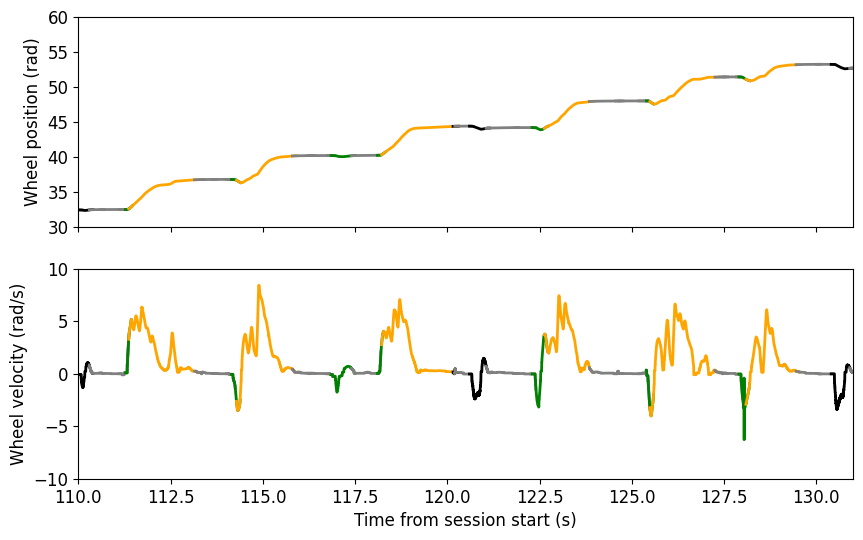

In [13]:
processed_quiescence['movement_duration'][:-1] = processed_quiescence['movement_duration'][1:]
movements = processed_quiescence['movement_onset'][0:].reset_index()
trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

colors_to_use_correct = ['black', 'grey', 'grey', 'green', 'orange']
colors_to_use_incorrect = ['black', 'grey', 'grey', 'red', 'orange']
colors_to_label_correct = ['Pre-quiescence', '', '', 'Correct choice', 'Post-choice']
colors_to_label_incorrect = ['Pre-quiescence', '', '', 'Incorrect choice', 'Post-choice']

# Plot wheel position and derivatives
metrics = ['wheel_pos', 'wheel_vel']
metric_labels = ['Wheel position (rad)', 'Wheel velocity (rad/s)']

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
new_df['wheel_acc'] = np.gradient(new_df['wheel_vel'], dt)
new_df['wheel_jit'] = np.gradient(new_df['wheel_acc'], dt)

fig, axs = plt.subplots(nrows=len(metrics), ncols=1, sharex=True, sharey=False, figsize=[10, 6])
plt.rc('font', size=12)

for me, metric in enumerate(metrics):
    
    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), metric]

        # Plot
        feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
        trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
        if feedback == 1.:
            colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
            use_label = colors_to_label_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        else:
            colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
            use_label = colors_to_label_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
            
        if movement_bool == 1.0:
            axs[me].plot(movement_time, movement_wheel, color=colors, label=use_label, linewidth=2)
        else:
            axs[me].plot(movement_time, movement_wheel, color='grey', linewidth=2)

    axs[len(metrics)-1].set_xlabel('Time from session start (s)')
    axs[me].set_ylabel(metric_labels[me])
    axs[len(metrics)-1].set_xlim([110, 131])  # 234-278  [110, 131]
    axs[0].set_ylim([30, 60])  #[30, 60]  [-10, 3]
    axs[1].set_ylim([-10, 10])
    # axs[0].legend(loc='upper left', bbox_to_anchor=(-.5, -0.5))


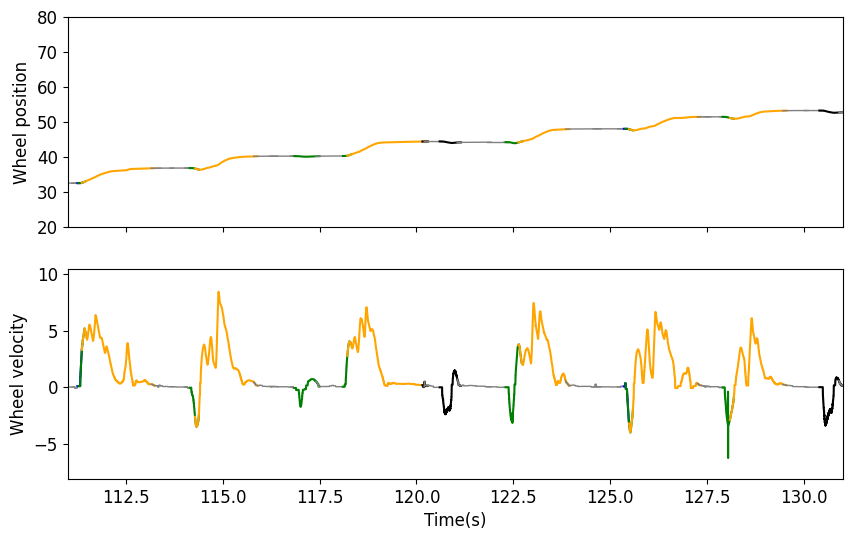

In [12]:
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, sharex=True, sharey=False, figsize=[10, 6])
plt.rc('font', size=12)

for me, metric in enumerate(metrics):
    
    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), metric]

        # Plot
        feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
        trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
        if feedback == 1.:
            colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        else:
            colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
        if movement_bool == 1.0:
            axs[me].plot(movement_time, movement_wheel, color=colors, label=trial_epoch)
        else:
            axs[me].plot(movement_time, movement_wheel, color='grey', linewidth=1)
    axs[len(metrics)-1].set_xlabel('Time(s)')
    axs[me].set_ylabel(metric_labels[me])
    axs[len(metrics)-1].set_xlim([111, 131])
    axs[0].set_ylim([20, 80])

# Across animals

### Fraction of total movement per trial epoch early and late in learning

In [7]:
# Loop through animals
fraction_all = pd.DataFrame(columns=['file_name', 'movement', 'trial_epoch', 'fraction', 'fraction_movement','mean_duration', 'learning_phase'])
mouse_fraction = pd.DataFrame(columns=['file_name', 'movement', 'trial_epoch', 'fraction', 'fraction_movement', 'mean_duration', 'learning_phase'])

for f, file in enumerate(data_files):
    if 'processed' in file:
        processed_quiescence = pickle.load(open(file, "rb"))
        processed_quiescence['movement_duration'][:-1] = processed_quiescence['movement_duration'][1:]  # TODO: need to remove this line after fixing at origin
        frac_epoch = pd.DataFrame(processed_quiescence.groupby(['movement', 'trial_epoch'])['movement_duration'].sum())
        frac_epoch = frac_epoch.reset_index(level=[0, 1])

        dur_epoch = pd.DataFrame(processed_quiescence.groupby(['trial', 'movement', 'trial_epoch'])['movement_duration'].sum())
        dur_epoch = dur_epoch.reset_index(level=[0, 1, 2])
        mean_dur_epoch = pd.DataFrame(processed_quiescence.groupby(['movement', 'trial_epoch'])['movement_duration'].mean())
        mean_dur_epoch = mean_dur_epoch.reset_index(level=[0, 1])
        mean_dur_epoch = mean_dur_epoch.rename(columns={'movement_duration': 'mean_duration'})

        frac_epoch = frac_epoch.merge(mean_dur_epoch, on=['movement', 'trial_epoch'])

        session_duration = np.max(processed_quiescence['movement_onset'])
        movement_duration = np.sum(frac_epoch.loc[frac_epoch['movement']==1.0, 'movement_duration'])
        frac_epoch['fraction'] = frac_epoch['movement_duration'] / session_duration
        frac_epoch['fraction_movement'] = frac_epoch['movement_duration'] / movement_duration

        # Save data
        mouse_fraction['movement'] = frac_epoch['movement']
        mouse_fraction['trial_epoch'] = frac_epoch['trial_epoch']
        mouse_fraction['fraction'] = frac_epoch['fraction']
        mouse_fraction['fraction_movement'] = frac_epoch['fraction_movement']
        mouse_fraction['mean_duration'] = frac_epoch['mean_duration']
        mouse_fraction['learning_phase'] = file[21:22]
        mouse_fraction['file_name'] = file

        if f == 0:
            fraction_all = mouse_fraction
        else:
            fraction_all = fraction_all.append(mouse_fraction)


/tmp/ipykernel_70959/3311065734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_quiescence['movement_duration'][:-1] = processed_quiescence['movement_duration'][1:]  # TODO: need to remove this line after fixing at origin
/tmp/ipykernel_70959/3311065734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_quiescence['movement_duration'][:-1] = processed_quiescence['movement_duration'][1:]  # TODO: need to remove this line after fixing at origin
/tmp/ipykernel_70959/3311065734.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

### Plot mean movement duration per learning phase

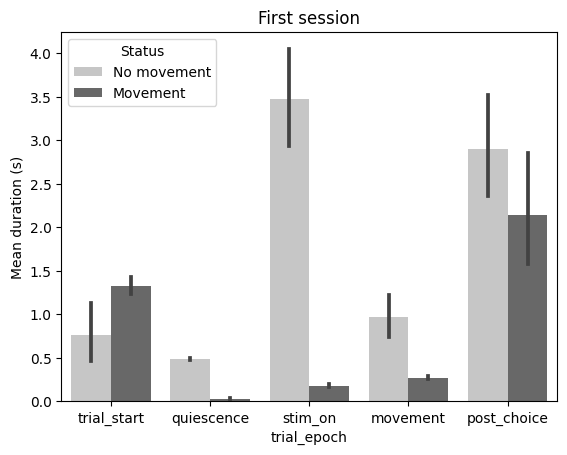

Text(0, 0.5, 'Mean duration (s)')

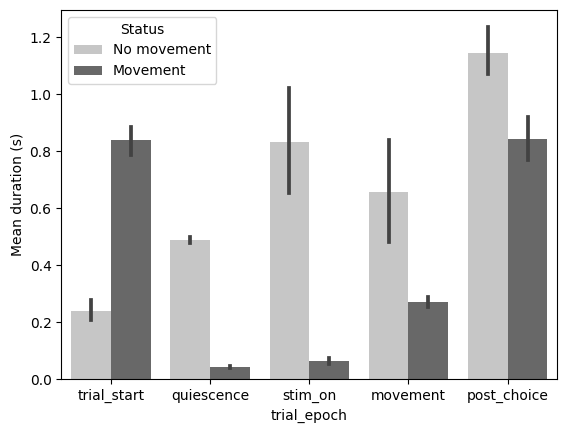

In [18]:

colors_to_use = sns.color_palette("Greys",2)

use_data = fraction_all.loc[fraction_all['learning_phase']=='1']
use_data.loc[use_data['movement'] ==0.0, 'movement'] = 'No movement'
use_data.loc[use_data['movement'] ==1.0, 'movement'] = 'Movement'
use_data = use_data.rename(columns={'movement': 'Status'})

sns.barplot(x='trial_epoch', y='mean_duration', hue='Status', data=use_data, order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.title('First session')
plt.ylabel('Mean duration (s)')
plt.show()
use_data = fraction_all.loc[fraction_all['learning_phase']=='l']
use_data.loc[use_data['movement'] ==0.0, 'movement'] = 'No movement'
use_data.loc[use_data['movement'] ==1.0, 'movement'] = 'Movement'
use_data = use_data.rename(columns={'movement': 'Status'})
sns.barplot(x='trial_epoch', y='mean_duration', hue='Status', data=use_data, order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.ylabel('Mean duration (s)')


Text(0, 0.5, 'Movement duration (s)')

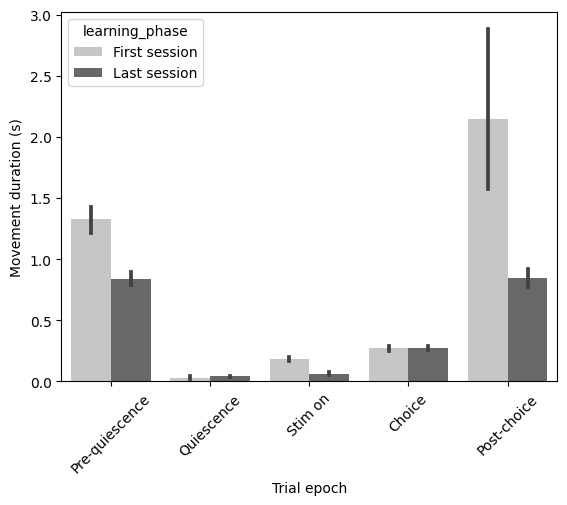

In [13]:
colors_to_use = sns.color_palette("Greys",2)
use_data = fraction_all.loc[fraction_all['movement']==1.0]
use_data.loc[use_data['learning_phase'] =='1', 'learning_phase'] = 'First session'
use_data.loc[use_data['learning_phase'] =='l', 'learning_phase'] = 'Last session'

sns.barplot(x='trial_epoch', y='mean_duration', hue='learning_phase', data=use_data, order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.xticks([0, 1, 2, 3, 4], ['Pre-quiescence', 'Quiescence', 'Stim on', 'Choice', 'Post-choice'], rotation=45)  # Orient x-axis ticks at 45 degrees
plt.xlabel('Trial epoch')
plt.ylabel('Movement duration (s)')


### Plot relative fraction of movement duration per learning phase

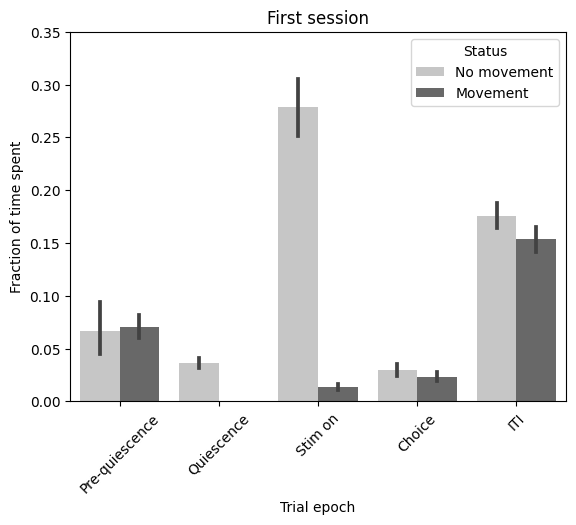

(0.0, 0.35)

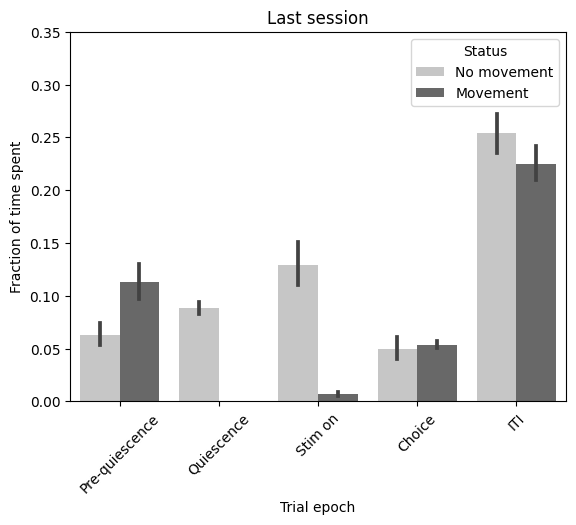

In [10]:
# sns.barplot(x='trial_epoch', y='fraction', hue='movement', data=fraction_all)
# use_data = fraction_all.loc[fraction_all['movement']==0.0]
# sns.barplot(x='trial_epoch', y='fraction_movement', hue='learning_phase', data=use_data)
colors_to_use = sns.color_palette("Greys",2)

use_data = fraction_all.loc[fraction_all['learning_phase']=='1']
use_data.loc[use_data['movement'] ==0.0, 'movement'] = 'No movement'
use_data.loc[use_data['movement'] ==1.0, 'movement'] = 'Movement'
use_data = use_data.rename(columns={'movement': 'Status'})

sns.barplot(x='trial_epoch', y='fraction', hue='Status', data=use_data,  order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.title('First session')
plt.xticks([0, 1, 2, 3, 4], ['Pre-quiescence', 'Quiescence', 'Stim on', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
plt.xlabel('Trial epoch')
plt.ylabel('Fraction of time spent')
plt.ylim([0, 0.35])
plt.show()
use_data = fraction_all.loc[fraction_all['learning_phase']=='l']
use_data.loc[use_data['movement'] ==0.0, 'movement'] = 'No movement'
use_data.loc[use_data['movement'] ==1.0, 'movement'] = 'Movement'
use_data = use_data.rename(columns={'movement': 'Status'})

sns.barplot(x='trial_epoch', y='fraction', hue='Status', data=use_data,  order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.title('Last session')
plt.xticks([0, 1, 2, 3, 4], ['Pre-quiescence', 'Quiescence', 'Stim on', 'Choice', 'ITI'], rotation=45)  # Orient x-axis ticks at 45 degrees
plt.xlabel('Trial epoch')
plt.ylabel('Fraction of time spent')
plt.ylim([0, 0.35])


Text(0, 0.5, 'Fraction of total movement time')

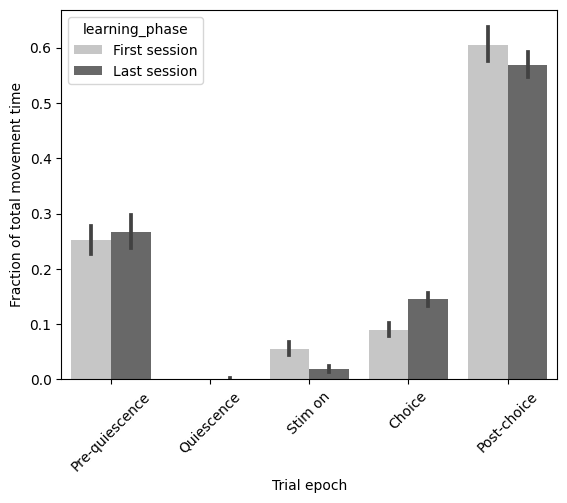

In [12]:
colors_to_use = sns.color_palette("Greys",2)
use_data = fraction_all.loc[fraction_all['movement']==1.0]
use_data.loc[use_data['learning_phase'] =='1', 'learning_phase'] = 'First session'
use_data.loc[use_data['learning_phase'] =='l', 'learning_phase'] = 'Last session'

sns.barplot(x='trial_epoch', y='fraction_movement', hue='learning_phase', data=use_data,  order=['trial_start', 
            'quiescence', 'stim_on', 'movement', 'post_choice'], palette=colors_to_use)
plt.xticks([0, 1, 2, 3, 4], ['Pre-quiescence', 'Quiescence', 'Stim on', 'Choice', 'Post-choice'], rotation=45)  # Orient x-axis ticks at 45 degrees
plt.xlabel('Trial epoch')
plt.ylabel('Fraction of total movement time')